In [2]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import math

import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import geopandas
from mpl_toolkits.basemap import Basemap

import netCDF4
import xarray as xr

# Understanding .nc datatype

.nc file contains geoinformation including longitude, latitude, time, and the parameter of interest such as sea surface temperature, emissions, or precipitation. To plot the graph, we need to match the dimension of the longitude and latitude of the map to the matrix of the parameter of interest. In the graph, we choose to take the average of the parameter of interest with respect to time.

In this section, we are using netCDF4 to retrieve information from the .nc file and using matplotlib/basemap to plot the resulting graph.


## Precipitation EDA

The following is the EDA and plot of the precipitation data. We noticed that the data is mostly gathered on land or near the coast, as precipitation cannot be measured in the open sea. Hence, the set of data will not be useful for us as features in open sea fishing activities with gear types like longliners. However, since some fishing gear types like trollers are located right off the coast, we will incorporate this data into certain training models and observe if the rain would make a difference in fishing activities. Here we are using the 2015 precipitation data to visualize results, but the selected years are merged into our dataset before training.

dict_keys(['lat', 'lon', 'time', 'precip'])


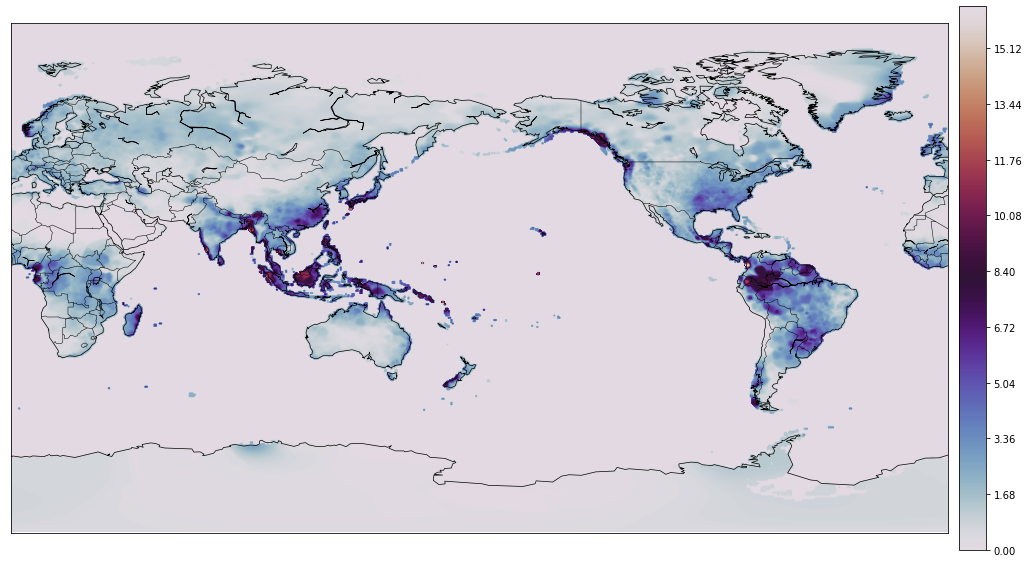

In [6]:
nc_file = '../data/precip.2015.nc'
nc = netCDF4.Dataset(nc_file, mode='r', compression='gzip')
print(nc.variables.keys())

precip = ma.array(nc.variables['precip'][:,:])
lats = nc.variables['lat'][:]
lons = nc.variables['lon'][:]
precip2 = precip.data
precip2[precip2 < -1] *= 0
precip1 = np.mean(precip2,axis=0)

m = Basemap(projection='gall', resolution='c',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

fig,ax=plt.subplots(figsize=(20,10))
cs = m.contourf(xi,yi,np.squeeze(precip1),  cmap='twilight', levels=300)
cb = fig.colorbar(cs, ax=ax, orientation='vertical', pad=0.01)
m.drawcoastlines(linewidth=0.7, zorder=10)
m.drawcountries(linewidth=0.5)

## Add precipitation as feature

The following section prepares the precipitation features like a grid to join our training data. The dataset consists of yearly precipitation data from 2012 to 2016. Transforming .nc data from a longitude range of 0 - 360 to -180 - 180. Round all df longitude and latitude data to nearest 0.5 degrees with a resolution of 1 degree. Adjust time to Datetime format with the date (yyyy-mm-dd) only format.

One of the limitations we find in adding features is the grid of longitude and latitude. All datasets have a different set of standards (different decimal places) when matching parameters to longitude and latitude grid. Due to computational power, we are unable to dice down the data to the finest grid/time combination, especially with large fishing activity data such as longliners.

In [3]:
def custom_round(x): 
    return 0.5 + np.floor(float(x))

def nc_to_df(file):
    nc = xr.open_dataset(file)
    df = nc.to_dataframe()
    df.reset_index(level=[0,1,2], inplace=True)
    df['time'] = df['time'].dt.to_period('M')
    df['lon'] = df['lon'] - 180
    df['lat'] = df['lat'].apply(lambda x: custom_round(x))
    df['lon'] = df['lon'].apply(lambda x: custom_round(x))
    df = df.groupby(['lat', 'lon', 'time']).mean()
    df.reset_index(level=[0,1,2], inplace=True)
    return df

In [4]:
df_precip_2012 = nc_to_df('precip.2012.nc')
df_precip_2013 = nc_to_df('precip.2013.nc')
df_precip_2014 = nc_to_df('precip.2014.nc')
df_precip_2015 = nc_to_df('precip.2015.nc')
df_precip_2016 = nc_to_df('precip.2016.nc')

In [5]:
df_precip = pd.concat([df_precip_2012, df_precip_2013, df_precip_2014, df_precip_2015, df_precip_2016])
df_precip.to_csv('../data/precip_grid.csv')
df_precip

,lat,lon,time,precip
0,-89.5,-179.5,2012-01,0.709112
1,-89.5,-179.5,2012-02,1.003529
2,-89.5,-179.5,2012-03,0.397314
3,-89.5,-179.5,2012-04,0.786810
4,-89.5,-179.5,2012-05,0.806670
...,...,...,...,...
777595,89.5,179.5,2016-08,NaN
777596,89.5,179.5,2016-09,NaN
777597,89.5,179.5,2016-10,NaN
777598,89.5,179.5,2016-11,NaN


### Test adding sst to AIS training data as additional feature

The section attempts to join the above precip to the trollers' dataset (feature_1.csv from adding the sst feature, please see feature_sst notebook) as an extra feature. The steps include adjusting the time to match the precipitation dataframe. Then both df is joined together with the 'is_fishing' column as the label and other columns as features.

In [6]:
path = '../data/feature_1.csv'

fishing_df = pd.read_csv(path)
fishing_df["adjust_time"] = pd.to_datetime(fishing_df['adjust_time']).dt.to_period('M')

In [7]:
df_all = pd.merge(fishing_df, df_precip,  how='left', \
                  left_on=['adjust_lat','adjust_lon', 'adjust_time'], \
                  right_on = ['lat','lon', 'time'])
df_all = df_all.drop(columns=['time', 'lat', 'lon'])
df_all.to_csv('../data/feature_2.csv')
df_all

,Unnamed: 0,is_fishing,lat_x,lon_x,course,speed,timestamp,distance_from_shore,distance_from_port,mmsi,source,adjust_lat,adjust_lon,adjust_time_date,adjust_time,sst,precip
0,0,1,38.243591,15.655180,309.200012,3.0,1.431005e+09,999.975464,11661.617188,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999,NaN
1,1,1,38.245487,15.658214,242.199997,8.4,1.431006e+09,999.975464,13038.084961,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999,NaN
2,2,1,38.245098,15.661433,311.200012,7.4,1.431007e+09,0.000000,12529.657227,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999,NaN
3,3,1,38.234615,15.640217,72.900002,6.1,1.431008e+09,0.000000,9433.749023,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999,NaN
4,4,1,38.240871,15.660789,340.399994,6.8,1.431009e+09,0.000000,12529.657227,7.652701e+13,gfw,38.5,15.5,2015-05-07,2015-05,13.099999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,7840,0,41.267307,36.381233,275.799988,0.0,1.446350e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000,NaN
7841,7841,0,41.267307,36.381222,12.000000,0.0,1.446351e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000,NaN
7842,7842,0,41.267334,36.381226,356.500000,0.0,1.446352e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000,NaN
7843,7843,0,41.267319,36.381226,0.000000,0.0,1.446353e+09,0.000000,5830.808594,2.740638e+14,gfw,41.5,36.5,2015-11-01,2015-11,16.388000,NaN
